In [1]:
import os
import sys
import datetime
from time import gmtime
from time import strftime
from pathlib import Path
from datetime import timedelta  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle
import librosa
import librosa.display
from feature_extraction import data_ls_to_string

from spectral_subtraction import spectral_subtraction

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2





# 2021 data

In [2]:
data = pd.read_csv("../data/annotations/inspections_2021.csv")

In [3]:
data = data.fillna(0)
data['Date'] = pd.to_datetime(data['Date'])
unique_hives = data['Tag number'].unique()
unique_hives

array([3629,    6, 3631, 3693, 3690, 3691, 3628, 3627, 3692, 3640])

In [4]:
grouped = data.groupby(['Tag number'])
dict_hives = {}
for i in unique_hives:
        dict_hives[i] = grouped.get_group(i)

In [5]:
for hive in  data['Tag number'].unique():
    dict_hives[hive] = dict_hives[hive].set_index(dict_hives[hive]['Date'])
    idx = pd.date_range(dict_hives[hive].index.min(), dict_hives[hive].index.max()+ timedelta(days=1), freq="15min")#  + timedelta(days=12)
    dict_hives[hive] = dict_hives[hive].reindex(idx)
    dict_hives[hive] = dict_hives[hive].drop(['Date'], axis=1)
    dict_hives[hive] = dict_hives[hive].interpolate(method="linear")#interpolate(method="ffill")
    dict_hives[hive]["fob"] = dict_hives[hive]["Fob 1st"] + dict_hives[hive]["Fob 2nd"]+ dict_hives[hive]["Fob 3rd"]
    dict_hives[hive]["fob"] = dict_hives[hive]["fob"]#.round(0).astype('f')

In [6]:
data = data.fillna(0)
data['Date'] = pd.to_datetime(data['Date']).dt.strftime("%Y-%m-%d")
data['fob'] = data["Fob 1st"] + data["Fob 2nd"]+ data["Fob 3rd"]
data= data.set_index(data['Date'])


In [7]:
# dead hives : 3640, 3629
#after winter: 3627, 3628, 3629, 3692

Text(0.5, 0, 'Number of frames of bees')

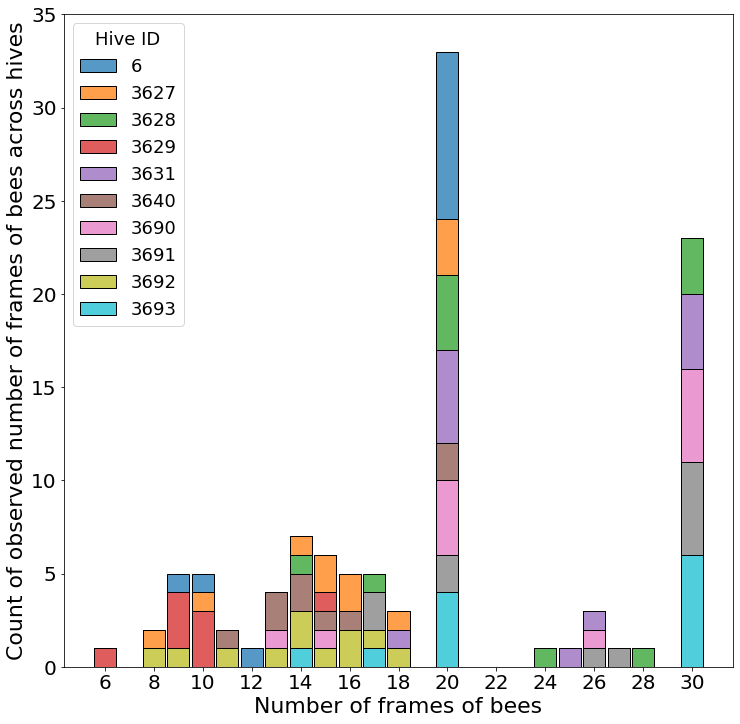

In [8]:
plt.rc('legend',fontsize=18) # using a size in points
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20


fig, ax = plt.subplots(figsize=(12, 12))

# Plotting the histogram
sns.histplot(
    data=data,
    x="fob",
    hue="Tag number",
    bins=np.arange(6, 32) - 0.5,
    multiple="stack",
    palette="tab10",
    ax=ax,  # Explicitly pass the axis
    shrink=0.9
)
#plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

legend = ax.get_legend()
if legend:
    legend.set_title("Hive ID")
    plt.setp(legend.get_title(), fontsize=18)  # Set legend title font size

#ax.set_xlim(1, 32)
    
ax.set_ylim(0, 35)

# Axis labels and title
plt.xticks(np.arange(6, 31, 2))
plt.ylabel("Count of observed number of frames of bees across hives", size=22)
plt.xlabel("Number of frames of bees", size=22)

#plt.savefig("fob_2021_by_hive.jpeg", dpi=400, bbox_inches="tight")


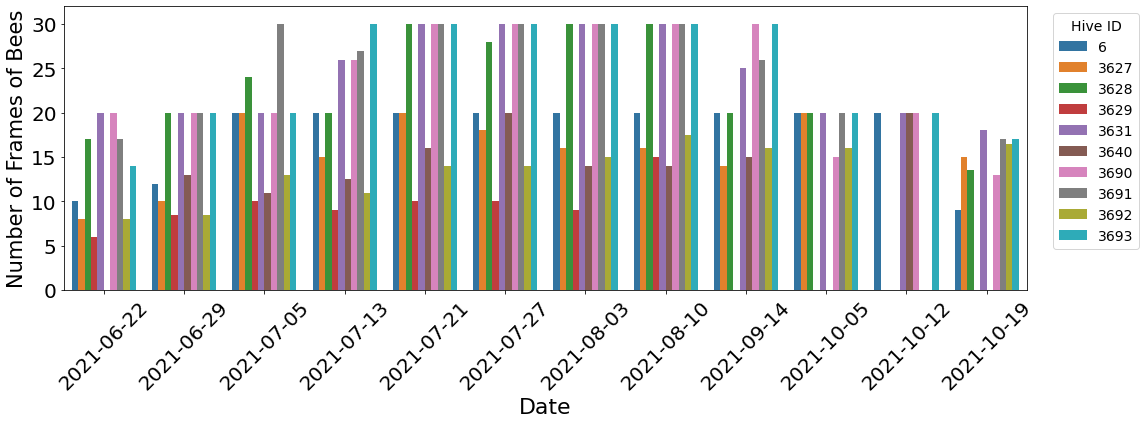

In [9]:
plt.rc('legend', fontsize=14)  # using a size in points
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

fig, ax = plt.subplots(figsize=(16, 6))

# Create the bar plot
sns.barplot(data=data, x=data.index, y='fob', hue="Tag number", ax=ax)

# Adjust the legend to appear outside the plot
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),  # Position the legend outside the plot
    ncol=1,  # Single column legend
    title="Hive ID"
)
plt.setp(ax.get_legend().get_title(), fontsize='14')  # Adjust legend title font size

ax.set_ylim(0, 32)


# Rotate x-axis labels
plt.xticks(rotation=45)

# Set axis labels
plt.ylabel('Number of Frames of Bees', size=21)
plt.xlabel('Date', size=22)

# Ensure the layout fits well
plt.tight_layout()

# Save the figure
#plt.savefig('fob_detailed_2021.png', dpi=400, bbox_inches="tight")


# read csv file 2022

In [40]:
data_2022 = pd.read_csv("../data/annotations/inspections_2022.csv")
data_2022['Date'] = pd.to_datetime(data_2022['Date'], dayfirst=True).dt.date
data_2022 = data_2022.set_index('Date')
data_2022['Tag number'] = data_2022['Tag number'].astype('int')

data_2022

,Tag number,Category,Action detail,Queen status,Is alive,Report notes
Date,,,,,,
2022-06-02,3627,hive status,queenright,queenright,1,nucs All qr. added second and queen excluders ...
2022-06-02,3627,hive grading,medium,queenright,1,nucs All qr. added second and queen excluders ...
2022-06-20,3627,hive grading,weak,queenright,1,NaN
2022-07-04,3627,hive grading,medium,queenright,1,7fob
2022-07-11,3627,hive grading,medium,queenright,1,7 frames of brood
...,...,...,...,...,...,...
2022-09-01,3629,varroa,2,queenright,1,NaN
2022-09-01,3629,treatment,mite away,queenright,1,NaN
2022-09-07,3629,frames of bees,5,queenright,1,Lots of dead bees under bee escape


# Varroa measurement

In [41]:
df_varroa = data_2022[data_2022['Category'] == 'varroa'][['Action detail', 'Tag number']]
df_varroa['Action detail'] = df_varroa['Action detail'].astype('f')
df_varroa['Tag number'] = df_varroa['Tag number'] .astype('int')

df_varroa.index = pd.to_datetime(df_varroa.index, dayfirst=True)
df_varroa['date'] = df_varroa.index
df_varroa['date'] = df_varroa['date'].dt.date

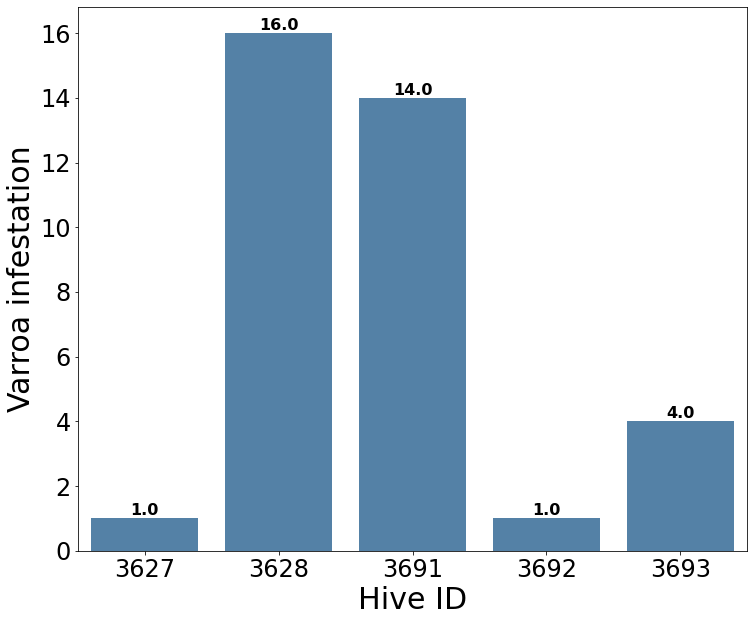

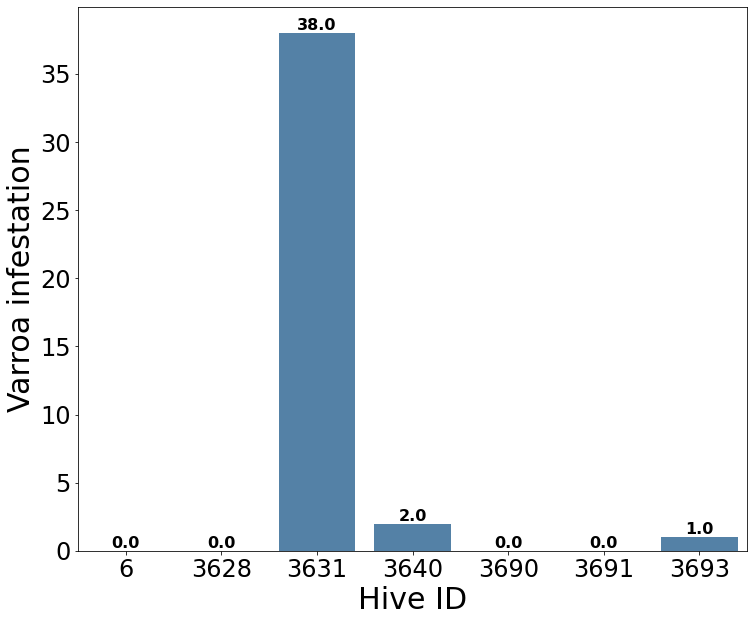

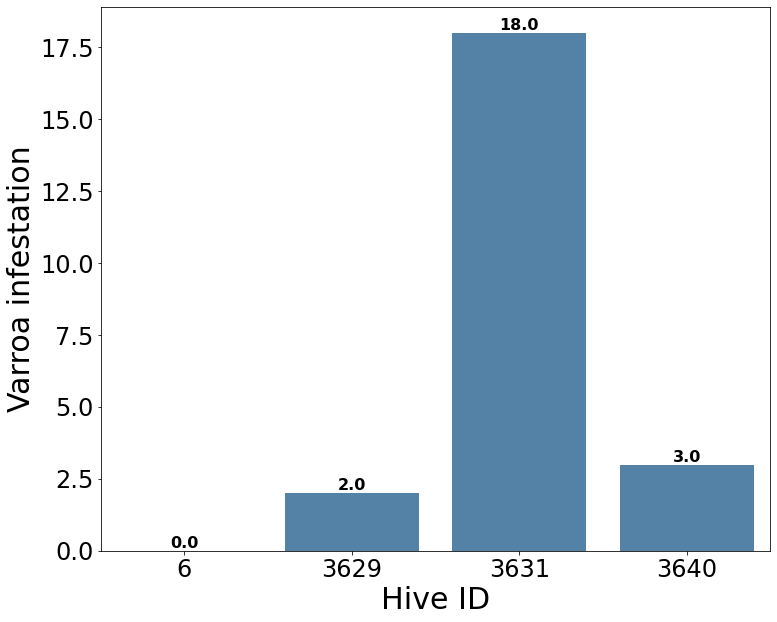

In [43]:
#df_varroa_temp
plt.rc('legend',fontsize=16) # using a size in points
plt.rcParams['xtick.labelsize'] = 24 
plt.rcParams['ytick.labelsize'] = 24 


for d in df_varroa.index.unique():
    
    df_varroa_temp = df_varroa.loc[d]

    df_varroa_temp = df_varroa_temp.sort_values('Tag number')
    fig, ax = plt.subplots(figsize=(12, 10))

    ax = sns.barplot(df_varroa_temp.sort_values('Tag number'), x="Tag number", y='Action detail', color='steelblue')

    for i, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), df_varroa_temp['Action detail'][i],
                ha='center', va='bottom', color='black', fontsize=16, weight='bold');

    plt.xlabel('Hive ID', size = 30)
    plt.ylabel('Varroa infestation', size = 30)
    #plt.title('Varroa infestation measurement on ' + str(d)[:10] , weight = 'bold')
    #plt.savefig('varroa' +  str(d)   + '.png', dpi=400) 


# Frames of bees

In [11]:
data_2022 = data_2022[data_2022['Category'] == 'frames of bees']
data_2022['Action detail'] = pd.to_numeric(data_2022['Action detail']) # conver the column from object to float
data_2022['Action detail'] = data_2022['Action detail'].astype('f') # covert from float to int
data_2022["fob"] = data_2022["Action detail"]
data_2022.index = pd.to_datetime(data_2022.index)


In [12]:
grouped = data_2022.groupby(['Tag number'])
dict_hives_2022 = {}
for i in data_2022['Tag number'].unique():
        dict_hives_2022[i] = grouped.get_group(i)

In [13]:
for hive in  data_2022['Tag number'].unique():
    idx = pd.date_range(dict_hives_2022[hive].index.min(), dict_hives_2022[hive].index.max(), freq="15min")
    dict_hives_2022[hive] = dict_hives_2022[hive].reindex(idx)
    dict_hives_2022[hive] = dict_hives_2022[hive].interpolate(method="linear")#interpolate(method="ffill")
    dict_hives_2022[hive]['fob'] = dict_hives_2022[hive]['fob'].round(0).astype('f')

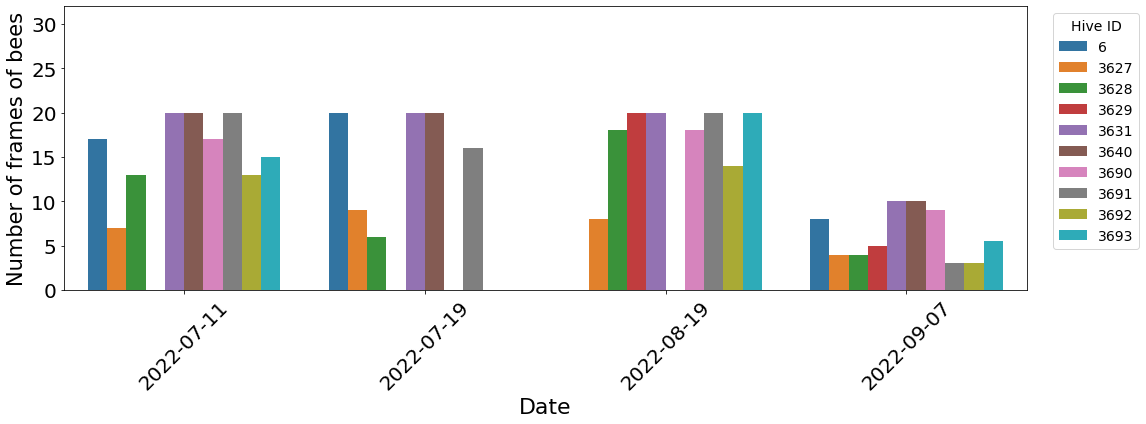

In [14]:
plt.rc('legend',fontsize=14) # using a size in points
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 


data_filtered = data_2022.loc[data_2022.index != '2022-08-16']
fig, ax = plt.subplots(figsize=(16,6), sharex=True)

sns.barplot(data_filtered, x=data_filtered.index.date, y='fob', hue="Tag number")
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),  # Position the legend outside the plot
    ncol=1,  # Single column legend
    title="Hive ID"
)
plt.setp(ax.get_legend().get_title(), fontsize='14')  # Adjust legend title font size
ax.set_ylim(0, 32)

plt.xticks(rotation=45)
plt.ylabel('Number of frames of bees', size = 21)
plt.xlabel('Date', size = 22)
plt.tight_layout()
#plt.savefig('fob_detailed_2022.png', dpi=400)


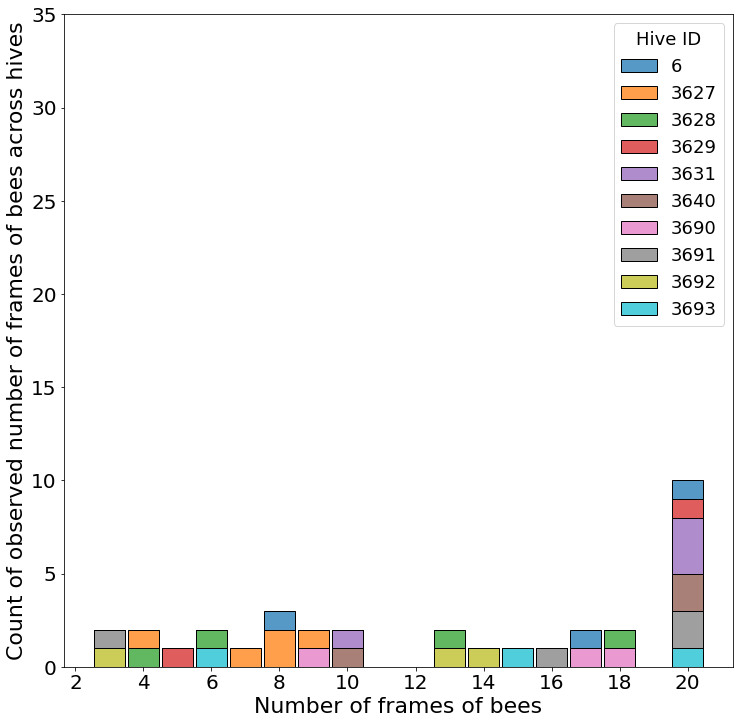

In [15]:
plt.rc('legend',fontsize=18) # using a size in points
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20

fig, ax = plt.subplots(figsize=(12, 12))

# Plotting the histogram
sns.histplot(
    data=data_2022,
    x="fob",
    hue="Tag number",
    bins=np.arange(3, 22) - 0.5, #np.arange(3, 22) - 0.5,
    multiple="stack",
    palette="tab10",
    ax=ax,  # Explicitly pass the axis
    shrink=0.9,
    legend=True
)


#plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
legend = ax.get_legend()

if legend:
    legend.set_title("Hive ID")
    plt.setp(legend.get_title(), fontsize=18)  # Set legend title font size
    
#ax.legend(title="Hive ID", loc='upper left', bbox_to_anchor=(-0.15, 1), fontsize=18, title_fontsize=18)
#ax.set_xlim(1, 32)
    
ax.set_ylim(0, 35)
#plt.xticks(np.arange(2, 31, 2))
plt.xticks(np.arange(2, 21,2))
plt.xlabel("Number of frames of bees", size=22)
plt.ylabel("Count of observed number of frames of bees across hives", size=22)
plt.savefig("fob_2022_by_hive.jpeg", dpi=400, bbox_inches="tight")
plt.show()


# Temperature and humidiity 

In [18]:
full_sensor_df= pd.read_csv("../data/temperature_humidity/sensor_2021.csv")
full_sensor_df

,Date,Tag number,temperature,humidity
0,2021-06-19 00:04:58+00:00,3629,26.24,35.45
1,2021-06-19 00:19:58+00:00,3629,26.01,35.92
2,2021-06-19 00:34:58+00:00,3629,25.84,35.90
3,2021-06-19 00:47:23+00:00,3629,26.24,35.99
4,2021-06-19 01:02:33+00:00,3629,26.25,36.15
...,...,...,...,...
80231,2021-10-31 22:52:47+00:00,3692,27.37,58.87
80232,2021-10-31 23:09:07+00:00,3692,27.40,58.75
80233,2021-10-31 23:24:22+00:00,3692,27.42,58.77
80234,2021-10-31 23:39:22+00:00,3692,27.07,58.87


In [19]:
grouped = full_sensor_df.groupby(['Tag number'])
sensors_hives = {}
for i in full_sensor_df['Tag number'].unique():
        sensors_hives[i] = grouped.get_group(i)

In [20]:
for hive in  full_sensor_df['Tag number'].unique():
    sensors_hives[hive]['Date'] = pd.to_datetime(sensors_hives[hive]['Date'])

    sensors_hives[hive] = sensors_hives[hive].set_index(sensors_hives[hive]['Date'])
    sensors_hives[hive] = sensors_hives[hive].drop(['Date'], axis=1)

In [21]:
resampled_sensor_hive = {}
x = {}
for hive in full_sensor_df['Tag number'].unique():
    x[hive] = sensors_hives[hive].resample('h').mean()
    idx = pd.date_range(x[hive].index.min(), x[hive].index.max() + timedelta(days=1) - 
                        pd.to_timedelta(x[hive].index.max().hour, unit='h')
                        - pd.to_timedelta(1, unit='h'), freq='H')
    x[hive] = x[hive].reindex(idx).interpolate(method="linear") #interpolate(method="spline", order=2, limit = 100, limit_direction='both')
    #x[hive] = x[hive].dropna(subset=['audio_density'])
    if len(x[hive]) > 0:
        resampled_sensor_hive[hive] = x[hive]

# Weather info

In [22]:
env = pd.read_csv("../data/weather_info/weather_2021_2022.csv")
env['Date/Time (LST)'] = pd.to_datetime(env['Date/Time (LST)'])

env = env.set_index(env['Date/Time (LST)'])
env = env.interpolate(method="ffill")

In [23]:
df = full_sensor_df

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])
df = df.drop(['Date'], axis=1)
#df = df.interpolate(method="ffill")
df = df.resample('h').mean()

df = df.groupby(df.index).mean()
idx = pd.date_range(df.index.min(), df.index.max() + timedelta(days=1) - 
                    pd.to_timedelta(df.index.max().hour, unit='h')
                    - pd.to_timedelta(1, unit='h'), freq='H')
df = df.reindex(idx).interpolate(method="linear")

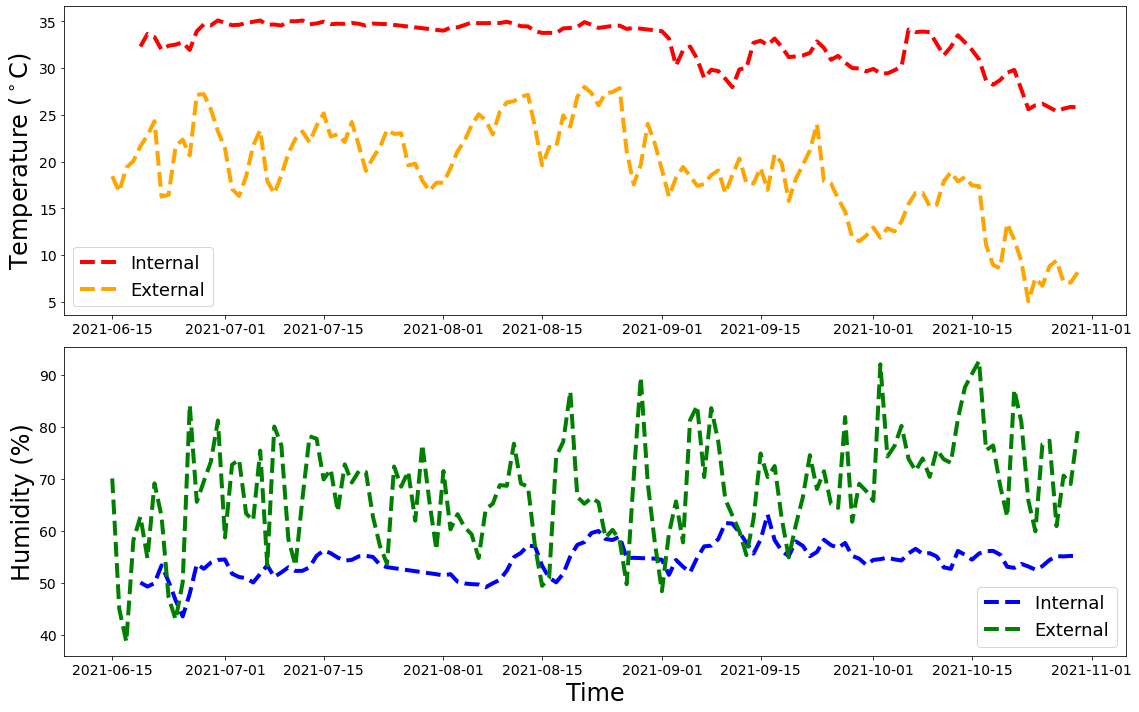

In [21]:
plt.rc('legend',fontsize=18) # using a size in points
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 


fig, ax = plt.subplots(figsize=(16,10))


plt.subplot(2, 1,1)
plt.plot(df['temperature'].loc['2021-06-15':'2021-10-30'].resample('d').mean(), color='red', linestyle='dashed',
linewidth=4, markersize=12, label = "Internal")
plt.plot(env['Temp (°C)'].loc['2021-06-15':'2021-10-30'].resample('d').mean(), color='orange', linestyle='dashed',
linewidth=4, markersize=12, label = "External")


#plt.xticks(sensors_hives[hive_id.hive_identity[hive]].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'temperature'].resample('30min').mean().index[0:48:4], idx_12.strftime('%H:%M'))
#plt.xlim([sensors_hives[hive_id.hive_identity[hive]].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'temperature'].resample('30min').mean().index.min(), sensors_hives[hive_id.hive_identity[hive]].loc['2021-8-12 00:00':'2021-8-13 00:00', 'temperature'].resample('15min').mean().index.max()])
plt.ylabel('Temperature ($^\circ$C)', size=24)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df['humidity'].loc['2021-06-15':'2021-10-30'].resample('d').mean(), color='blue', linestyle='dashed',
linewidth=4, markersize=12, label = "Internal ")
plt.plot(env['Rel Hum (%)'].loc['2021-06-15':'2021-10-30'].resample('d').mean(), color='green', linestyle='dashed',
linewidth=4, markersize=12, label = "External")



#plt.xticks(sensors_hives[hive_id.hive_identity[hive]].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'humidity'].resample('30min').mean().index[0:48:4], idx_12.strftime('%H:%M'))
#plt.xlim([sensors_hives[hive_id.hive_identity[hive]].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'humidity'].resample('30min').mean().index.min(), sensors_hives[hive_id.hive_identity[hive]].loc['2021-8-12 00:00':'2021-8-13 00:00', 'temperature'].resample('15min').mean().index.max()])
plt.ylabel('Humidity (%)', size=24)
plt.xlabel('Time', size=24)

plt.legend()

plt.tight_layout()
plt.savefig('temp_humid_total_2021.png')
#plt.close('all')

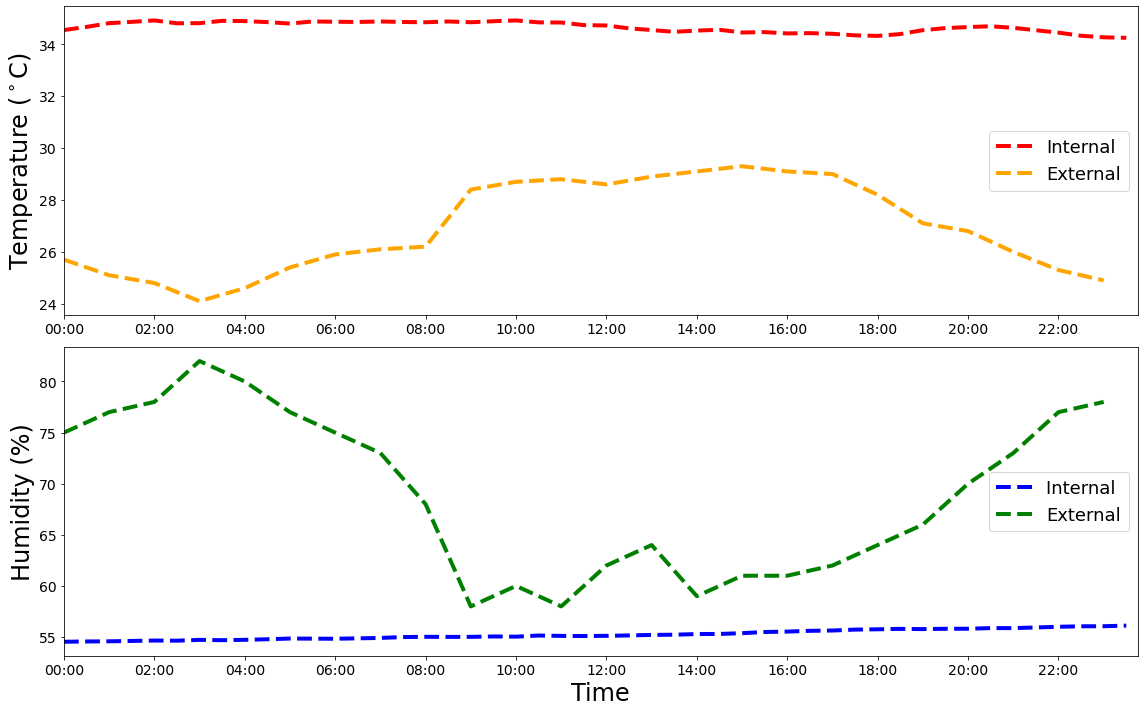

In [27]:
plt.rc('legend',fontsize=18) # using a size in points
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 

date = '2021-08-12'
hive = 3631

data_path = "../data/files/"  # Adjust the path as needed


bee_12h = np.load(data_path + str(hive) + '_' + str(date) + '_12h.npy')
ls_dates  = np.load(data_path + str(hive) + '_' + str(date) + '_times.npy', allow_pickle=True)


idx_12 = pd.date_range(ls_dates[0], periods=12, freq="2H")

fig, ax = plt.subplots(figsize=(16,10))


plt.subplot(2, 1,1)
plt.plot(sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1),
                                 'temperature'].resample('30min').mean().interpolate(method="linear"), color='red', linestyle='dashed',
     linewidth=4, markersize=12, label = "Internal")
plt.plot(env['Temp (°C)'][date], color='orange', linestyle='dashed',
     linewidth=4, markersize=12, label = "External")


plt.xticks(sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'temperature'].resample('30min').mean().index[0:48:4], idx_12.strftime('%H:%M'))
plt.xlim([sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'temperature'].resample('30min').mean().index.min(), 
          sensors_hives[hive].loc['2021-8-12 00:00':'2021-8-13 00:00', 'temperature'].resample('15min').mean().index.max()])
plt.ylabel('Temperature ($^\circ$C)', size=24)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'humidity'].resample('30min').mean().interpolate(method="linear"), color='blue', linestyle='dashed',
     linewidth=4, markersize=12, label = "Internal ")
plt.plot(env['Rel Hum (%)'][date], color='green', linestyle='dashed',
     linewidth=4, markersize=12, label = "External")

plt.xticks(sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'humidity'].resample('30min').mean().index[0:48:4], idx_12.strftime('%H:%M'))
plt.xlim([sensors_hives[hive].loc[pd.to_datetime(date):pd.to_datetime(date)+ timedelta(days=1), 'humidity'].resample('30min').mean().index.min(),
          sensors_hives[hive].loc['2021-8-12 00:00':'2021-8-13 00:00', 'temperature'].resample('15min').mean().index.max()])
plt.ylabel('Humidity (%)', size=24)
plt.xlabel('Time', size=24)

plt.legend()

plt.tight_layout()
plt.savefig('paper_temp_humid_12h_'+ str(hive) + '_' + str(date) +'.png')
#plt.close('all')

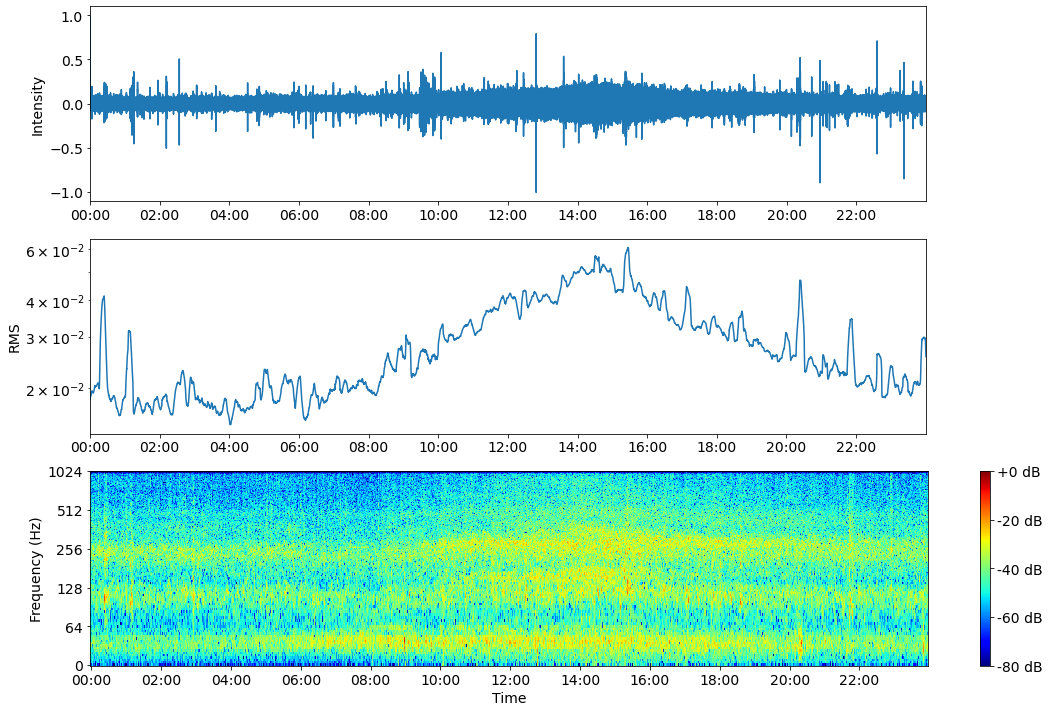

In [28]:
plt.rcParams['agg.path.chunksize'] = 10000

plt.rc('legend',fontsize=16) # using a size in points
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

date = '2021-08-16'
hive = 3691

data_path = "../data/files/"  # Adjust the path as needed

bee_12h = np.load(data_path + str(hive) + '_' + str(date) + '_12h.npy')
ls_dates = np.load(data_path + str(hive) + '_' + str(date) + '_times.npy', allow_pickle=True)

rolling = 1000

rms=librosa.feature.rms(y=bee_12h, S=None, frame_length=2048, hop_length=512, center=True, pad_mode='constant')

ma_rms = pd.Series(rms.reshape(-1)).rolling(rolling).mean()

idx_12 = pd.date_range(ls_dates[0], periods=12, freq="2H")
min15_size = int((ma_rms.shape[0] - rolling + 1)/len(ls_dates)) #48
min15_size_raw = int(bee_12h.shape[0]/len(ls_dates)) #48

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)


ax3 = plt.subplot2grid(shape=(3, 5), loc=(0, 0), colspan=4)

ax1 = plt.subplot2grid(shape=(3, 5), loc=(1, 0), colspan=4)
ax2 = plt.subplot2grid(shape=(3, 5), loc=(2, 0), colspan=5)

ax3.plot(bee_12h)
ax3.set_ylabel('Intensity', size=14)#Amplitude
ax3.set_xticks(np.arange(len(ls_dates)*min15_size_raw)[0:len(ls_dates)*min15_size_raw:4*min15_size_raw])
ax3.set_xticklabels(idx_12.strftime('%H:%M'))
ax3.axis(xmin=0,xmax=bee_12h.shape[-1])

ax1.semilogy(ma_rms.T[rolling:], label='Beehive')
ax1.set_xticks(np.arange(len(ls_dates)*min15_size)[0:len(ls_dates)*min15_size:4*min15_size]+rolling)
ax1.set_xticklabels(idx_12.strftime('%H:%M'))

ax1.set_ylabel('RMS', size=14)
ax1.set_xticks(np.arange(len(ls_dates)*min15_size)[0:len(ls_dates)*min15_size:4*min15_size]+rolling)
ax1.set_xticklabels(idx_12.strftime('%H:%M'))

ax1.axis(xmin=rolling,xmax=ma_rms.shape[0])


spec=librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(bee_12h, n_fft=512), ref=np.max), sr=2048,  y_axis='log', cmap='jet')
plt.colorbar(spec, format="%+2.0f dB")
min15_size = int((librosa.stft(bee_12h, n_fft=512).shape[1])/len(ls_dates)) #48

ax2.set_xticks(np.arange(len(ls_dates)*min15_size)[0:len(ls_dates)*min15_size:4*min15_size]+rolling,)
ax2.set_xticklabels(idx_12.strftime('%H:%M'))

ax2.set_ylabel('Frequency (Hz)', size=14)
ax2.set_xlabel('Time', size=14)

plt.tight_layout()
#plt.savefig('paper_spect_bee_'+ str(hive) + '_' + str(date) +'_' + 'rolling_' + str(rolling) +'.png')


# Raw audio and rms

In [29]:
win = 1600
shift= 800


rms_2021 = pd.read_pickle("../data/features/2021_df_raw_rms_win_" + str(win) +'_shift_' + str(shift) +"_pkl")
rms_2022 = pd.read_pickle("../data/features/2022_df_raw_rms_win_" + str(win) +'_shift_' + str(shift) +"_pkl")

rms_2021['date'] = pd.to_datetime(rms_2021['date'], dayfirst=True)
rms_2021 = rms_2021.set_index(rms_2021['date'])
rms_2021 = rms_2021.drop(['date'], axis=1)

rms_2022['date'] = pd.to_datetime(rms_2022['date'], dayfirst=True)
rms_2022 = rms_2022.set_index(rms_2022['date'])
rms_2022 = rms_2022.drop(['date'], axis=1)

In [30]:
df_all = rms_2021

df_24h = pd.DataFrame(columns=df_all.columns)

for hive in df_all["tag"].unique():

        print(hive)

        df = df_all[df_all["tag"]==hive].resample('h').mean()
        df = df.dropna(how='all')

        for date in np.unique(df.index.date):

            temp_date = df.loc[str(date)]
            #temp = temp.between_time(start, stop)
            if len(temp_date) == 24:
                #print(len(temp_date))
                print(date)
                print(len(temp_date))
                
                #df_24h = df_24h.drop(df_24h[(df_24h['tag'] == hive) & (df_24h.index.isin(temp_date.index))].index)
                df_24h = df_24h.append(df.loc[str(date)])
                #print(len(df_24h))

0
2021-08-06
24
2021-08-07
24
2021-08-08
24
2021-08-09
24
2021-08-12
24
2021-08-13
24
2021-08-14
24
2021-08-15
24
2021-08-16
24
2021-08-25
24
2021-08-26
24
2021-09-15
24
2021-09-16
24
2021-09-17
24
2021-09-22
24
2021-09-23
24
2021-09-24
24
2021-09-25
24
2021-09-26
24
2021-10-08
24
2021-10-09
24
2021-10-10
24
2021-10-11
24
2021-10-12
24
6
2021-08-12
24
2021-08-25
24
2021-09-15
24
2021-09-16
24
2021-09-17
24
2021-09-18
24
2021-09-22
24
2021-09-23
24
3627
2021-09-15
24
2021-09-16
24
2021-09-17
24
2021-09-18
24
2021-10-14
24
2021-10-15
24
2021-10-16
24
2021-10-17
24
2021-10-18
24
2021-10-19
24
2021-10-20
24
2021-10-21
24
2021-10-22
24
2021-10-27
24
2021-10-28
24
2021-10-30
24
2021-10-31
24
3628
2021-08-13
24
2021-08-14
24
2021-08-15
24
2021-08-16
24
3629
2021-08-12
24
2021-08-13
24
2021-08-14
24
2021-08-25
24
2021-08-26
24
2021-08-27
24
2021-08-28
24
2021-09-15
24
2021-09-16
24
2021-09-17
24
2021-09-18
24
2021-09-19
24
2021-09-20
24
2021-09-21
24
2021-10-23
24
2021-10-24
24
3631
2021-08-12

In [31]:
for hive in df_24h["tag"].unique():

        print(hive)
        #df = df_all[df_all["tag"]==hive].resample('h').mean()
        #df = df.dropna(how='all')
        df = df_24h[df_24h["tag"]==hive]
        for date in np.unique(df.index.date):

            temp_date = df.loc[str(date)]
            #temp = temp.between_time(start, stop)
            if len(temp_date) < 24:
                #print(len(temp_date))
                print(date)
                

0.0
6.0
3627.0
3628.0
3629.0
3631.0
3640.0
3690.0
3691.0
3692.0
3693.0


[   6. 3640. 3627. 3692.]
720
{datetime.date(2021, 9, 22), datetime.date(2021, 9, 21), datetime.date(2021, 9, 19), datetime.date(2021, 9, 20), datetime.date(2021, 8, 25), datetime.date(2021, 9, 18), datetime.date(2021, 8, 28), datetime.date(2021, 8, 13), datetime.date(2021, 8, 26), datetime.date(2021, 9, 15), datetime.date(2021, 8, 27), datetime.date(2021, 9, 17), datetime.date(2021, 8, 12), datetime.date(2021, 8, 14), datetime.date(2021, 9, 23), datetime.date(2021, 9, 16)}
7.5
[3631. 3690. 3693. 3628. 3691.]
936
{datetime.date(2021, 9, 22), datetime.date(2021, 9, 21), datetime.date(2021, 9, 19), datetime.date(2021, 9, 20), datetime.date(2021, 8, 25), datetime.date(2021, 9, 18), datetime.date(2021, 8, 28), datetime.date(2021, 8, 13), datetime.date(2021, 8, 26), datetime.date(2021, 9, 15), datetime.date(2021, 8, 27), datetime.date(2021, 9, 17), datetime.date(2021, 8, 12), datetime.date(2021, 8, 14), datetime.date(2021, 9, 23), datetime.date(2021, 9, 16)}
7.8
[   6. 3631. 3640. 3690. 369

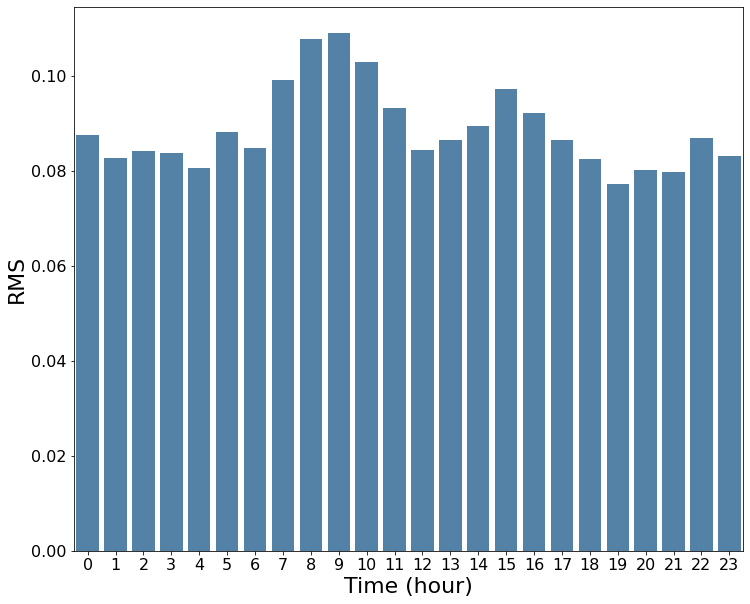

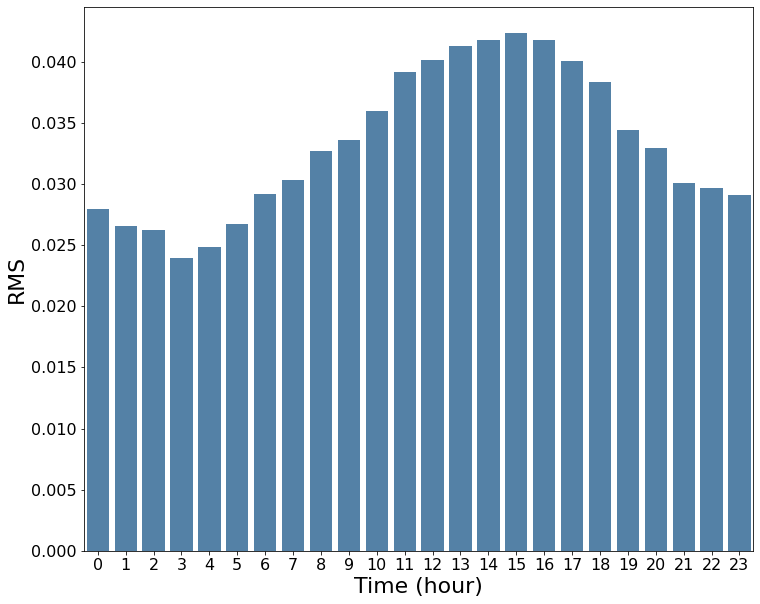

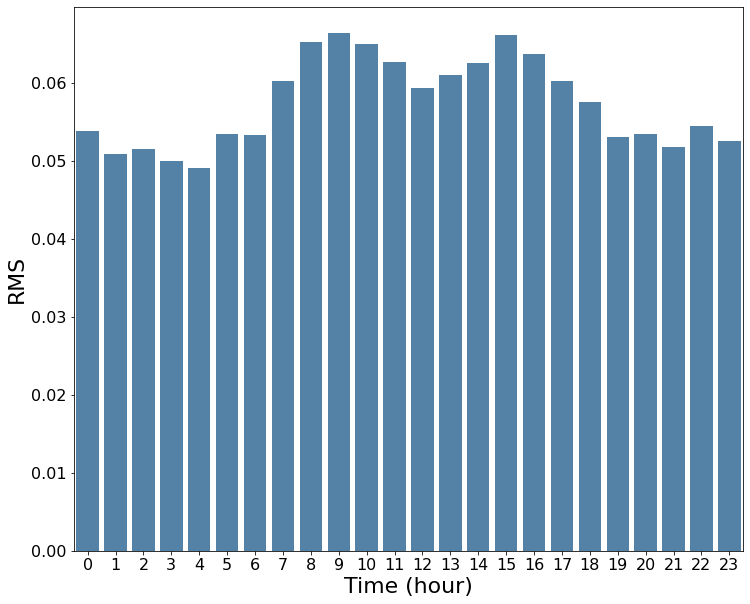

In [33]:
plt.rc('legend',fontsize=16) # using a size in points
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

idx = [[10, 20], [20, 30], [1, 30]]

index_mutual=df_24h[(10 < df_24h["fob"]) &  (df_24h["fob"] <= 20)].index.intersection(df_24h[(20 < df_24h["fob"]) &  (df_24h["fob"] <= 30)].index)

for j in range(len(idx)):
    
    df_all_masked=df_24h[(idx[j][0] < df_24h["fob"]) &  (df_24h["fob"] <= idx[j][1])].loc[index_mutual]
    print(df_all_masked['tag'].unique())
    print(len(df_all_masked.index.date))
    print(set(df_all_masked.index.unique().date))
    print(len(df_all_masked.index.date)/df_all_masked['tag'].nunique()/24)
    
    #df_all_masked = df_all_masked.resample('h').mean()
    fig, ax = plt.subplots(figsize=(12, 10))

    res = df_all_masked.groupby(df_all_masked.index.hour).mean()
    sns.barplot(data=res, x=res.index,  y='rms', color='steelblue')
    plt.xlabel('Time (hour)', size=22)
    plt.ylabel('RMS', size=22)
    #plt.savefig('Average rms of bee hives_' + str(idx[j][0]) + "_" + str(idx[j][1])  + '_same_dates.png', dpi=400) 


# Spectral subtraction

Time taken for spectral subtraction for this file: 13.489567995071411 seconds


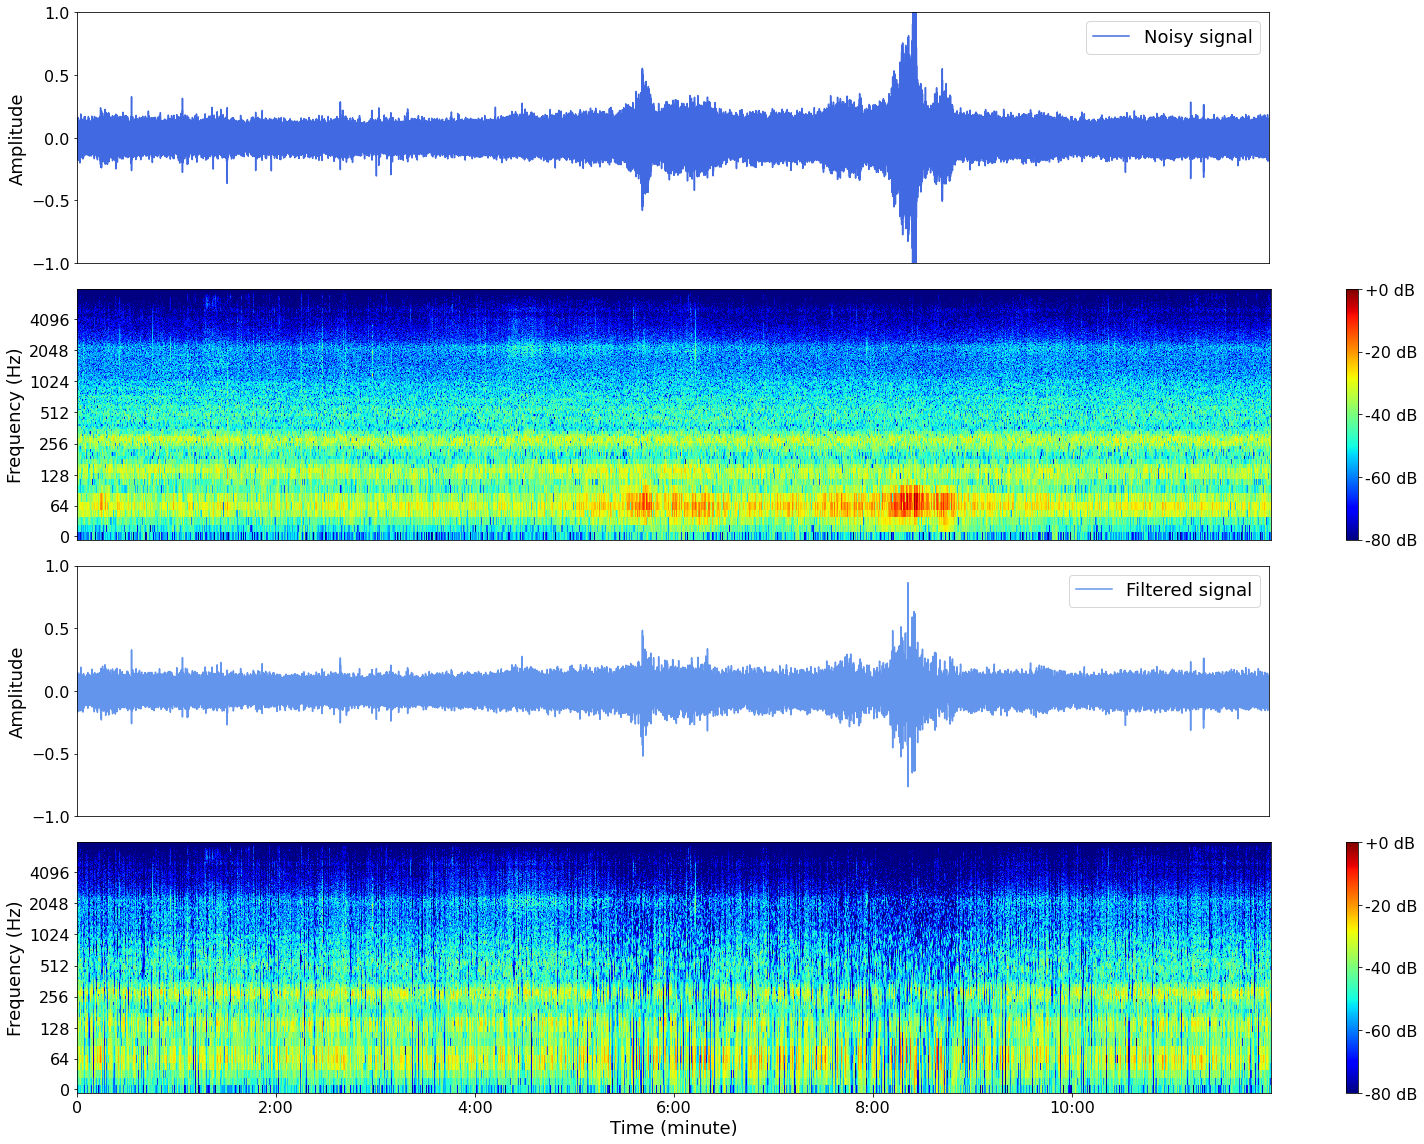

In [34]:
hive_name = "05-06-2022_17h30_HIVE-3640.wav"
sample_rate=16000

signal_bee, sample_rate = librosa.load(os.path.join("../data/audio/test/", hive_name), sr=sample_rate)

shift = 2622861
signal_bee_realigned = signal_bee[shift:]
x_hat_mag = spectral_subtraction(signal_bee_realigned, snr_threshold=1.5, window_time=30e-3, sample_rate = sample_rate)
x_hat_mag = np.nan_to_num(x_hat_mag, nan=0)


plt.rc('legend',fontsize=18) # using a size in points
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 

sample_rate = 16000


bins = np.arange(len(signal_bee_realigned))[0:(len(signal_bee_realigned)):16000*120]
xlabels = ["0", "2:00", "4:00", "6:00", "8:00", "10:00", "12:00", "14:00"]

fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(22)

# Update grid shape to accommodate all subplots
ax1 = plt.subplot2grid(shape=(4, 5), loc=(0, 0), colspan=4)
ax2 = plt.subplot2grid(shape=(4, 5), loc=(1, 0), colspan=5)
ax3 = plt.subplot2grid(shape=(4, 5), loc=(2, 0), colspan=4)
ax4 = plt.subplot2grid(shape=(4, 5), loc=(3, 0), colspan=5)

# Plot on ax1
ax1.plot(signal_bee_realigned, label='Noisy signal', color='royalblue')
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.axis(xmin=0, xmax=signal_bee_realigned.shape[0])
ax1.set_ylabel('Amplitude', size=18)
ax1.axis(ymin=-1, ymax=1)
ax1.legend(loc='upper right')

# Spectrogram for ax2
spec_stft = librosa.stft(signal_bee_realigned, n_fft=1024)# , hop_length=800
spec = librosa.display.specshow(librosa.amplitude_to_db(spec_stft, ref=np.max), sr=16000, y_axis='log', cmap='jet', ax=ax2)
#plt.ylim(0, 1000)

ax2.set_ylabel('Frequency (Hz)', size=18)
fig.colorbar(spec, ax=ax2, format='%+2.0f dB')
#ax2.axis( ymax=1000)


# Plot on ax3
ax3.plot(x_hat_mag, label='Filtered signal', color='cornflowerblue')
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.axis(xmin=0, xmax=x_hat_mag.shape[0])
ax3.set_ylabel('Amplitude', size=18)
ax3.axis(ymin=-1, ymax=1)
ax3.legend(loc='upper right')

spec_stft = librosa.stft(x_hat_mag, n_fft=1024)
spec = librosa.display.specshow(librosa.amplitude_to_db(spec_stft, ref=np.max), sr=16000, y_axis='log', cmap='jet', ax=ax4)

ax4.set_xticks(np.arange(0, spec_stft.shape[1], int(spec_stft.shape[1] / len(bins) + 1)))
ax4.set_xticklabels(xlabels[:len(bins)])
ax4.set_ylabel('Frequency (Hz)', size=18)
ax4.set_xlabel('Time (minute)', size=18)
fig.colorbar(spec, ax=ax4, format='%+2.0f dB')
#ax4.axis( ymax=1000)

plt.tight_layout()
#plt.savefig('noisy_filtered_spectrogram.jpeg', dpi=400)
